# Chapter 2. Small Worlds and Large Worlds

In [1]:
import arviz as az

import matplotlib.pyplot as plt

from jax import lax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
from numpyro.contrib.autoguide import (AutoContinuousELBO,
                                       AutoLaplaceApproximation)
import numpyro.distributions as dist
from numpyro.infer import SVI
import numpyro.optim as optim

%config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")

### Code 2.1

In [2]:
ways = np.array([0., 3, 8, 9, 0])
ways / np.sum(ways)

DeviceArray([0.  , 0.15, 0.4 , 0.45, 0.  ], dtype=float32)

### Code 2.2

In [3]:
np.exp(dist.Binomial(total_count=9, probs=0.5).log_prob(6))

DeviceArray(0.16406256, dtype=float32)

### Code 2.3

In [4]:
# define grid
p_grid = np.linspace(start=0, stop=1, num=20)

# define prior
prior = np.repeat(1, 20)

# compute likelihood at each value in grid
likelihood = np.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / np.sum(unstd_posterior)

### Code 2.4

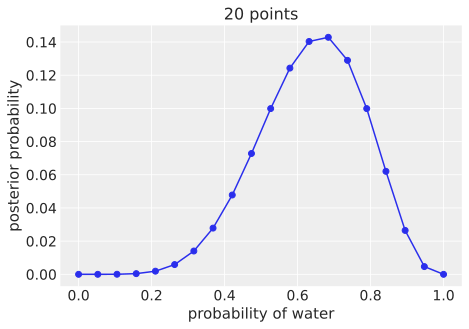

In [5]:
plt.plot(p_grid, posterior, "-o")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title("20 points");

### Code 2.5

In [6]:
prior = np.where(p_grid < 0.5, 0, 1)
prior = np.exp(-5 * abs(p_grid - 0.5))

### Code 2.6

In [7]:
def model(W, L):
    p = numpyro.sample("p", dist.Uniform(0, 1))  # uniform prior
    numpyro.sample("W", dist.Binomial(W + L, p), obs=W)  # binomial likelihood

guide = AutoLaplaceApproximation(model)

# SVI -> Stochastic Variable Inference ??
svi = SVI(model, guide, optim.Adam(1), AutoContinuousELBO(), W=6, L=3)

# funky numpyro random variable thing.
init_state = svi.init(PRNGKey(0))
state = lax.fori_loop(0, 1000, lambda i, x: svi.update(x)[0], init_state)
params = svi.get_params(state)

# display summary of quadratic approximation
# samples is a dict a keys 'p' 
# guide is a parameterized dist function
# params are somehow pulled from svi after running it a bit...

samples = guide.sample_posterior(PRNGKey(1), params, (1000,))
samples['p'].shape

(1000,)

In [8]:
numpyro.diagnostics.print_summary(samples, prob=0.89, group_by_chain=False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         p      0.62      0.14      0.63      0.41      0.84    845.27      1.00



### Code 2.7

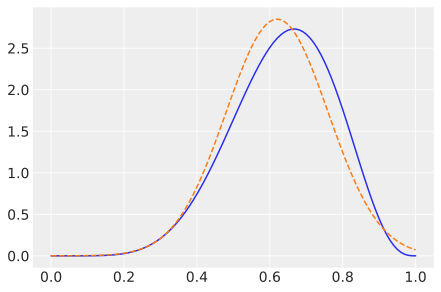

In [13]:
# analytical calculation
W = 6
L = 3
x = np.linspace(0, 1, 101)
plt.plot(x, np.exp(dist.Beta(W + 1, L + 1).log_prob(x)))
# quadratic approximation
plt.plot(x, np.exp(dist.Normal(0.62, 0.14).log_prob(x)), "--");

In [10]:
import altair as alt
import pandas as pd

In [27]:
def d2df( d ): 
    dct = d
    if type(d) != dict:
        dct = {'x':d[0], 'y':d[1]}
        
    return pd.DataFrame(dct)



In [29]:
base = alt.Chart( d2df( {'x':x, 'y': np.exp(dist.Beta(W + 1, L + 1).log_prob(x))}) ).encode(
x='x:Q',
y='y:Q')
df = d2df([x, np.exp(dist.Normal(0.62, 0.14).log_prob(x)) ] )
normal = alt.Chart(df).mark_line().encode(
    x='x:Q',
    y='y:Q'
)

base.mark_point() + base.mark_line() + normal

alt.LayerChart(...)


### Code 2.8

In [9]:
n_samples = 1000
p = [np.nan] * n_samples
p[0] = 0.5
W = 6
L = 3
with numpyro.handlers.seed(rng=0):
    for i in range(1, n_samples):
        p_new = numpyro.sample("p_new", dist.Normal(p[i - 1], 0.1))
        p_new = np.abs(p_new) if p_new < 0 else p_new
        p_new = 2 - p_new if p_new > 1 else p_new
        q0 = np.exp(dist.Binomial(W + L, p[i - 1]).log_prob(W))
        q1 = np.exp(dist.Binomial(W + L, p_new).log_prob(W))
        u = numpyro.sample("u", dist.Uniform())
        p[i] = p_new if u < q1 / q0 else p[i - 1]

### Code 2.9

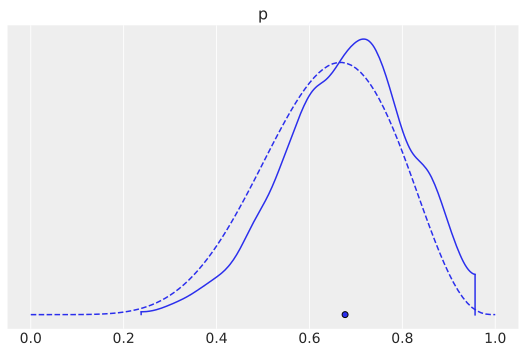

In [10]:
az.plot_density({"p": p}, credible_interval=1)
plt.plot(x, np.exp(dist.Beta(W + 1, L + 1).log_prob(x)), "--");